In [1]:
# Célula 1: Carregando Bibliotecas e Dados
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carregando o nosso dataset limpo
path_dados = '../data/processed/censo_cnpq_unificado_2023.csv'
df = pd.read_csv(path_dados)

print("Dataset carregado com sucesso!")
df.head()

Dataset carregado com sucesso!


,CO_IES,NO_IES,SG_IES,NO_MUNICIPIO_IES,SG_UF_IES,TP_CATEGORIA_ADMINISTRATIVA,QT_DOC_EX_DOUT,QT_DOC_EX_MEST,nome_ies_padronizado,total_bolsas_cnpq,...,PCI - Programa de Capacitação Institucional,PDE - Pós-doutorado no Exterior,PDI - Pos-doutorado Empresarial,PDJ - Pós-doutorado Júnior,PDS - Pós-doutorado Sênior,PQ - Produtividade em Pesquisa,PV - Pesquisador Visitante,SET - Fixação de Recursos Humanos,SWE - Doutorado Sanduíche no Exterior,SWP - Doutorado-Sanduiche no Pais
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,UFMT,Cuiabá,MT,1,1263,191,universidade federal de mato grosso,534,...,0,0,0,4,0,67,0,0,0,0
1,2,UNIVERSIDADE DE BRASÍLIA,UNB,Brasília,DF,1,2550,224,universidade de brasilia,1684,...,0,0,0,20,10,405,0,0,0,0
2,3,UNIVERSIDADE FEDERAL DE SERGIPE,UFS,São Cristóvão,SE,1,1456,210,universidade federal de sergipe,534,...,0,0,0,5,1,84,0,0,0,1
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS,UFAM,Manaus,AM,1,1217,537,universidade federal do amazonas,404,...,0,0,0,4,0,54,0,0,0,0
4,5,UNIVERSIDADE FEDERAL DO PIAUÍ,UFPI,Teresina,PI,1,1142,250,universidade federal do piaui,496,...,0,0,0,2,1,72,0,9,0,0


In [2]:
# Célula 2: Preparação dos Dados para o Modelo
# Modelos de machine learning funcionam melhor com dados numéricos e na mesma escala.

# 1. Selecionar as 'features' (características) que usaremos para agrupar as IES.
# Vamos usar as quantidades de docentes e o total de bolsas.
features = ['QT_DOC_EX_DOUT', 'QT_DOC_EX_MEST', 'total_bolsas_cnpq']
df_ml = df[features].copy()

# 2. Remover IES com valores zerados em todas as features, pois não adicionam informação ao cluster.
df_ml = df_ml[(df_ml.T != 0).any()]

# 3. Padronizar os dados (Standard Scaling)
# Isso é crucial para algoritmos como K-Means, que são sensíveis à escala das variáveis.
# O StandardScaler transforma os dados para que tenham média 0 e desvio padrão 1.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_ml)

print("Dados preparados e padronizados para o modelo de clusterização.")
print("Formato do array de dados padronizados:", df_scaled.shape)

Dados preparados e padronizados para o modelo de clusterização.
Formato do array de dados padronizados: (2545, 3)


Agora que os dados estão preparados (padronizados e escalados), podemos aplicar os algoritmos de Machine Learning.

Clusterização com K-Means e PCA

Encontrando o Número Ideal de Clusters (Método do Cotovelo)
O método do cotovelo consiste em rodar o K-Means para vários números de clusters (de 1 a 10, por exemplo) e calcular a "inércia" para cada um. A inércia é a soma das distâncias quadradas das amostras ao centro do cluster mais próximo. Procuramos o ponto no gráfico onde a queda da inércia diminui drasticamente, formando um "cotovelo".

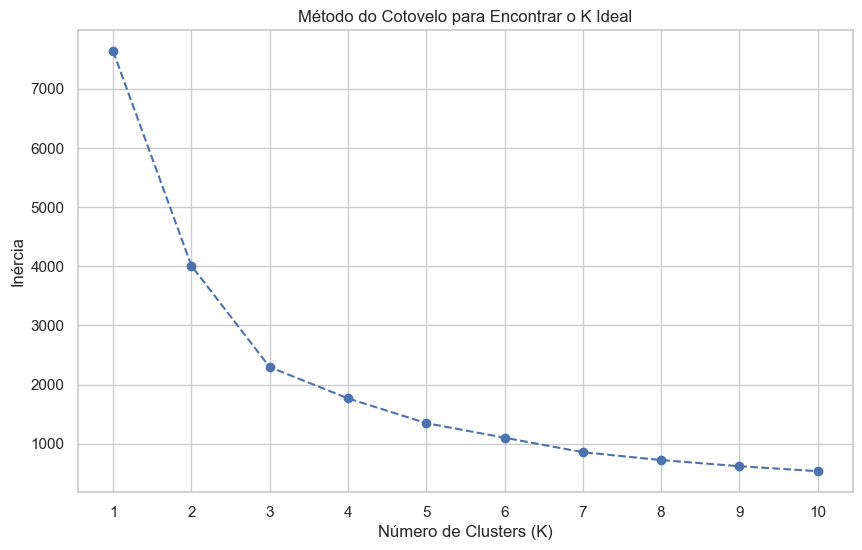

In [3]:
# Célula 3: Aplicando o Método do Cotovelo (Elbow Method)

# Lista para armazenar a inércia de cada modelo
inertia = []

# Range de clusters para testar
k_range = range(1, 11)

for k in k_range:
    # Cria e treina o modelo K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    # Adiciona a inércia do modelo à lista
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Encontrar o K Ideal')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Análise: Olhe o gráfico que será gerado. Você verá a inércia diminuindo à medida que K aumenta. O "cotovelo" é o ponto de inflexão. Para dados de IES, é comum que K=3 ou K=4 seja um bom ponto de partida (ex: "Pequenas", "Médias" e "Grandes"). Vamos assumir que o cotovelo está em K=3 para os próximos passos.

Executando o K-Means e Atribuindo os Clusters
Agora que escolhemos nosso K, vamos rodar o modelo final e adicionar a qual cluster cada instituição pertence.

In [4]:
# Célula 4: Rodando o Modelo K-Means com o K escolhido

# Definindo o número ideal de clusters
K_IDEAL = 3

# Criando e treinando o modelo final
kmeans = KMeans(n_clusters=K_IDEAL, random_state=42, n_init=10)
kmeans.fit(df_scaled)

# Adicionando a etiqueta do cluster ao nosso DataFrame original
# Primeiro, pegamos os índices do df_ml para garantir que a atribuição seja correta
df.loc[df_ml.index, 'cluster'] = kmeans.labels_

print(f"Clusterização com K={K_IDEAL} concluída.")
df.head()

Clusterização com K=3 concluída.


,CO_IES,NO_IES,SG_IES,NO_MUNICIPIO_IES,SG_UF_IES,TP_CATEGORIA_ADMINISTRATIVA,QT_DOC_EX_DOUT,QT_DOC_EX_MEST,nome_ies_padronizado,total_bolsas_cnpq,...,PDE - Pós-doutorado no Exterior,PDI - Pos-doutorado Empresarial,PDJ - Pós-doutorado Júnior,PDS - Pós-doutorado Sênior,PQ - Produtividade em Pesquisa,PV - Pesquisador Visitante,SET - Fixação de Recursos Humanos,SWE - Doutorado Sanduíche no Exterior,SWP - Doutorado-Sanduiche no Pais,cluster
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,UFMT,Cuiabá,MT,1,1263,191,universidade federal de mato grosso,534,...,0,0,4,0,67,0,0,0,0,2.0
1,2,UNIVERSIDADE DE BRASÍLIA,UNB,Brasília,DF,1,2550,224,universidade de brasilia,1684,...,0,0,20,10,405,0,0,0,0,1.0
2,3,UNIVERSIDADE FEDERAL DE SERGIPE,UFS,São Cristóvão,SE,1,1456,210,universidade federal de sergipe,534,...,0,0,5,1,84,0,0,0,1,2.0
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS,UFAM,Manaus,AM,1,1217,537,universidade federal do amazonas,404,...,0,0,4,0,54,0,0,0,0,2.0
4,5,UNIVERSIDADE FEDERAL DO PIAUÍ,UFPI,Teresina,PI,1,1142,250,universidade federal do piaui,496,...,0,0,2,1,72,0,9,0,0,2.0


Analisando as Características de Cada Cluster
O que significa pertencer ao cluster 0, 1 ou 2? Vamos agrupar por cluster e calcular a média das nossas features para entender o "perfil" de cada grupo.

In [5]:
# Célula 5: Analisando os Centros dos Clusters

# Adicionamos as features originais ao dataframe de ml para facilitar a análise
df_ml['cluster'] = kmeans.labels_

# Calculando a média das features para cada cluster
cluster_profile = df_ml.groupby('cluster').mean()

print("Perfil médio de cada cluster:")
print(cluster_profile)

Perfil médio de cada cluster:
         QT_DOC_EX_DOUT  QT_DOC_EX_MEST  total_bolsas_cnpq
cluster                                                   
0             23.608898       28.884322           1.695339
1           2554.000000      250.650000        1922.150000
2            518.636364      299.709091         149.909091


Insight: A tabela de saída desta célula é muito rica. Você provavelmente verá que:

Cluster 0: Pode ter valores baixos em todas as features (IES pequenas, focadas no ensino).
Cluster 1: Pode ter valores intermediários (IES médias, em desenvolvimento de pesquisa).
Cluster 2: Pode ter valores muito altos (as grandes potências de pesquisa, com muitos doutores e bolsas).

Visualizando os Clusters com PCA
Nossos dados têm 3 dimensões (QT_DOC_EX_DOUT, QT_DOC_EX_MEST, total_bolsas_cnpq). Para visualizá-los em um gráfico 2D, precisamos reduzir essas dimensões. Usaremos a Análise de Componentes Principais (PCA) para isso.

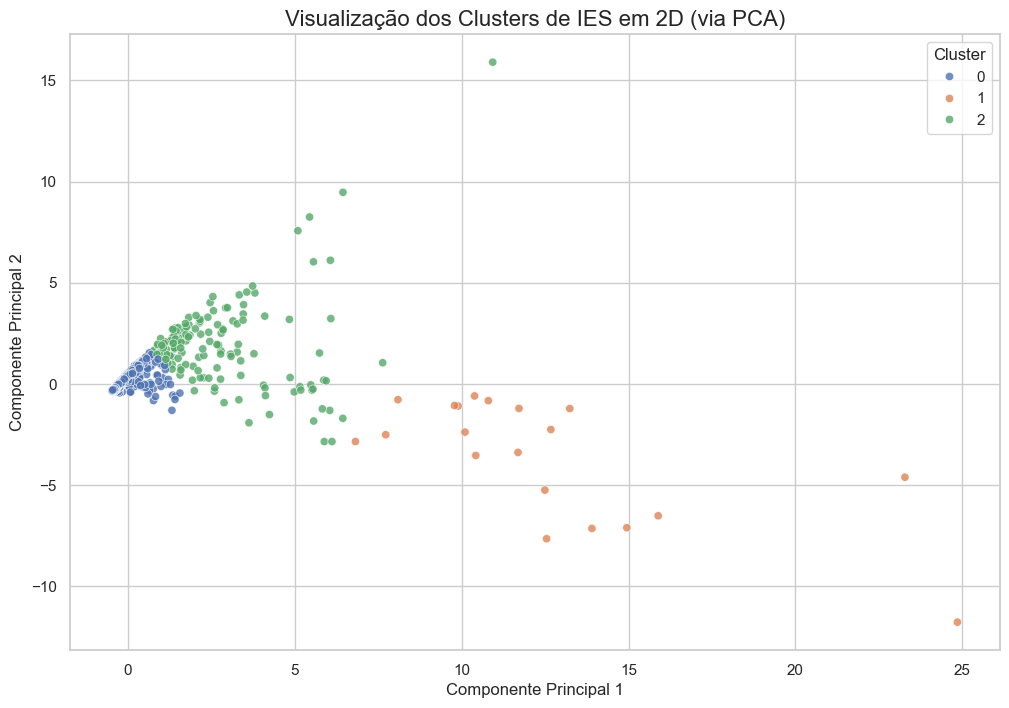

In [6]:
# Célula 6: Redução de Dimensionalidade com PCA e Visualização

# 1. Aplicar o PCA para reduzir para 2 componentes
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# 2. Criar um novo DataFrame com os componentes principais e os clusters
df_pca = pd.DataFrame(data=df_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
df_pca['cluster'] = kmeans.labels_

# 3. Criar o gráfico de dispersão dos clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Componente Principal 1',
    y='Componente Principal 2',
    hue='cluster',
    data=df_pca,
    palette='deep',
    alpha=0.8
)

plt.title('Visualização dos Clusters de IES em 2D (via PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.show()

Insight: Este gráfico final nos mostra a "separação" dos grupos. Se os clusters estiverem bem definidos, você verá nuvens de pontos de cores diferentes agrupadas em regiões distintas do gráfico. Isso confirma que nosso modelo conseguiu encontrar padrões significativos nos dados.